In [148]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [149]:
import sys
sys.path.append("vae")

In [153]:
from vae.vae import VAE

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR10
from torchvision.utils import make_grid
import torchvision.transforms as T
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization

from tqdm import tqdm
import matplotlib.pyplot as plt

In [154]:
!ls lightning_logs

version_0  version_1  version_2  version_3  version_4  version_5  version_6


In [155]:
vae = VAE.load_from_checkpoint("lightning_logs/version_3/checkpoints/epoch=493.ckpt")
vae.eval();

In [156]:
vae.prior, vae.posterior

('normal', 'normal')

In [157]:
ds = CIFAR10("data", train=False, transform=T.Compose([T.ToTensor(), cifar10_normalization()]))
mean = cifar10_normalization().mean
std = cifar10_normalization().std

In [158]:
num_imgs = 16

In [159]:
imgs = torch.stack([ds[i][0] for i in range(0, num_imgs)])
with torch.no_grad():
    x = vae.encoder(imgs)
    mu = vae.fc_mu(x)
    reconst = vae.decoder(mu)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


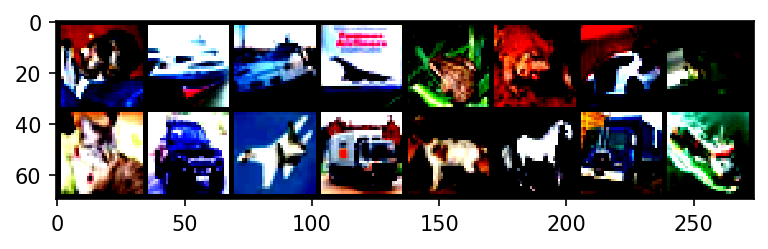

In [160]:
plt.figure(dpi=150)    
plt.imshow(make_grid(imgs).permute(1, 2, 0).numpy())
plt.savefig("figures/input.png", bbox_inches='tight')

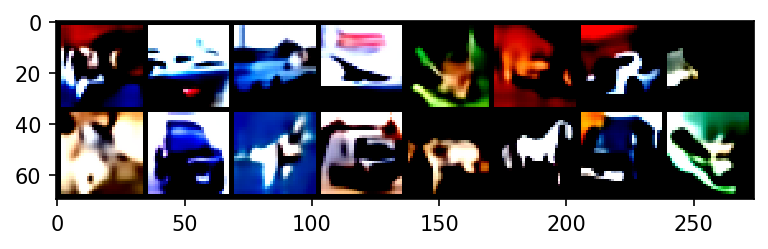

In [161]:
plt.figure(dpi=150)    
plt.imshow(make_grid(reconst).permute(1, 2, 0).numpy())
plt.savefig("figures/reconst.png", bbox_inches='tight')

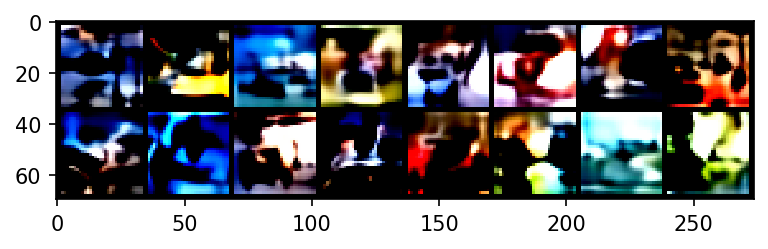

In [162]:
with torch.no_grad():
    z = torch.randn_like(mu)
    gen = vae.decoder(z).squeeze()
plt.figure(dpi=150)    
plt.imshow(make_grid(gen).permute(1, 2, 0).numpy())
plt.savefig("figures/sample.png", bbox_inches='tight')

In [163]:
from sklearn.manifold import TSNE

def tsne(model, dataset):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.eval()
    model = model.to(device)
    dl = DataLoader(dataset, batch_size=512, num_workers=6)
    mus = []
    ys = []
    for x, y in tqdm(dl):
        with torch.no_grad():
            x = model.encoder(x.to(device))
            mu = model.fc_mu(x)
            mus.append(mu)
        ys.append(y)
        
    mu = torch.cat(mus).cpu().numpy()
    y = torch.cat(ys).numpy()
    embed = TSNE(n_components=2).fit_transform(mu)
    return embed, y

In [145]:
embed, y = tsne(vae, ds)

100%|██████████| 20/20 [00:01<00:00, 16.92it/s]


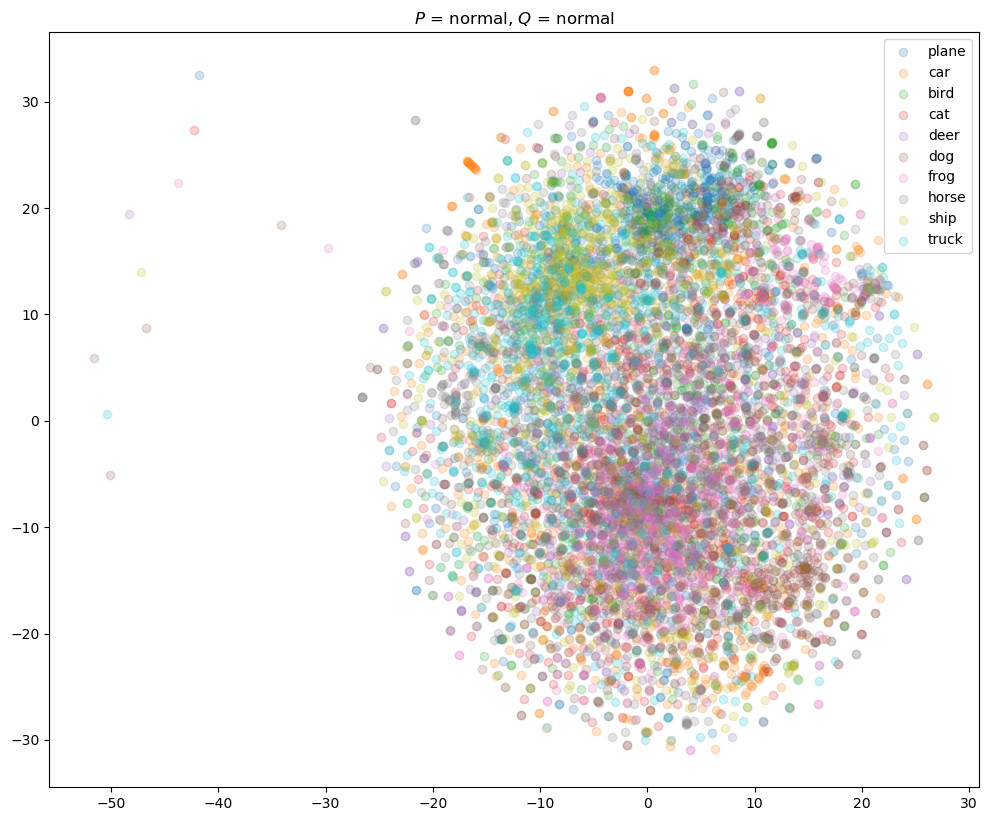

In [146]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(dpi=100, figsize=(12, 10))
for i, c in enumerate(classes):
    idx = y == i
    plt.scatter(embed[idx, 0], embed[idx, 1], alpha=0.2, label=c)
plt.legend()
plt.title(f"$P$ = {vae.prior}, $Q$ = {vae.posterior}") 
plt.savefig("figures/tsne.png", bbox_inches='tight')